### Check input files



In [114]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('../datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../datasets/train_data.csv
../datasets/firstDataset.csv


### Import train data and create DataFrame object

In [115]:
rawsData = pd.read_csv('../datasets/firstDataset.csv')
print("The files have been imported")


The files have been imported


In [116]:
len(rawsData)


1048575

In [117]:
rawsData.keys()


Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [118]:
selectedData = rawsData
allDatasetToTest = rawsData


In [119]:
def getSliceFromRawData():
    return rawsData[['Protocol',
                         'Fwd Pkt Len Max',
                         'Fwd Pkt Len Max',
                         'Bwd Pkt Len Mean',
                         'Fwd Pkt Len Std',
                         'Bwd Pkt Len Max',
                         'Bwd Pkt Len Min',
                         'Bwd Pkt Len Std',
                         'Pkt Len Min',
                         'Pkt Len Max',
                         'PSH Flag Cnt',
                         'ACK Flag Cnt',
                         'Fwd Seg Size Avg',
                         'Init Fwd Win Byts',
                         'Fwd Act Data Pkts',
                         'Fwd Seg Size Min',
                         'Label']].copy()

In [120]:
selectedData = getSliceFromRawData()
allDatasetToTest = getSliceFromRawData()

In [121]:
withoutDuplicates = selectedData.drop_duplicates()


In [122]:
len(withoutDuplicates)


50812

### DataFrame information
#### The `info()` method provides us a basic information about featurs, like: feature's amout of data (how many values are NaN values) and the types of data (e.q int or float). It is very important information for future data processing beacuse, e.q: fetures which contains variables of type 'int' will be labeled differently than features which contains variables of type 'float'.

In [123]:
withoutDuplicates.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50812 entries, 0 to 1048570
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Protocol           50812 non-null  int64  
 1   Fwd Pkt Len Max    50812 non-null  int64  
 2   Fwd Pkt Len Max    50812 non-null  int64  
 3   Bwd Pkt Len Mean   50812 non-null  float64
 4   Fwd Pkt Len Std    50812 non-null  float64
 5   Bwd Pkt Len Max    50812 non-null  int64  
 6   Bwd Pkt Len Min    50812 non-null  int64  
 7   Bwd Pkt Len Std    50812 non-null  float64
 8   Pkt Len Min        50812 non-null  int64  
 9   Pkt Len Max        50812 non-null  int64  
 10  PSH Flag Cnt       50812 non-null  int64  
 11  ACK Flag Cnt       50812 non-null  int64  
 12  Fwd Seg Size Avg   50812 non-null  float64
 13  Init Fwd Win Byts  50812 non-null  int64  
 14  Fwd Act Data Pkts  50812 non-null  int64  
 15  Fwd Seg Size Min   50812 non-null  int64  
 16  Label              5

In [124]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)


def showAttackDistribution(data):
    normal = 'Benign'
    ftpAttack = 'FTP-BruteForce'
    sshAttack = 'SSH-Bruteforce'
    fig = go.Figure(data=[
        go.Bar(name=normal,
               y=data.value_counts().values[0:1],
               x=[normal],
               text=data.value_counts()[0:1],
               orientation='v',
               textposition='outside',),
        go.Bar(name=ftpAttack,
               y=data.value_counts().values[1:2],
               x=[ftpAttack],
               text=data.value_counts()[1:2],
               orientation='v',
               textposition='outside',),
        go.Bar(name=sshAttack,
               y=data.value_counts().values[2:],
               x=[sshAttack],
               text=data.value_counts()[2:],
               orientation='v',
               textposition='outside',)
    ])
    # Change the bar mode
    fig.update_layout(
        width=800,
        height=600,
        title=f'Labels Distribution',
        yaxis_title='Number of attacks',
        xaxis_title='Attack Name',)
    iplot(fig)


In [125]:
showAttackDistribution(withoutDuplicates['Label'])


In [126]:
def shortData(data, featureName):
    shortedNormal = data[data[featureName] == 'Benign'][:6000]
    shortedFTP = data[data[featureName] == 'FTP-BruteForce']
    shortedSSH = data[data[featureName] == 'SSH-Bruteforce']
    return pd.concat([shortedNormal, shortedFTP, shortedSSH], axis=0)


In [127]:
toTrainModel = shortData(withoutDuplicates, 'Label')
showAttackDistribution(toTrainModel['Label'])


In [128]:

def makeOnlyAttackOrNot(dataToTransform):
    columnToTransform = ['Label']
    for colKey in columnToTransform:
        dataToTransform[colKey] = dataToTransform[colKey].map(
            lambda i: 0 if i == 'Benign' else 1)
        # dataToTransform[colKey] = LabelEncoder().fit_transform(dataToTransform[colKey])

    return dataToTransform


In [129]:
toTrainModel = makeOnlyAttackOrNot(toTrainModel)


In [130]:
allDatasetToTest = makeOnlyAttackOrNot(allDatasetToTest)


### Heatmap
#### Heatmap provide us information on how much the individual features are interpedent. 

<AxesSubplot:>

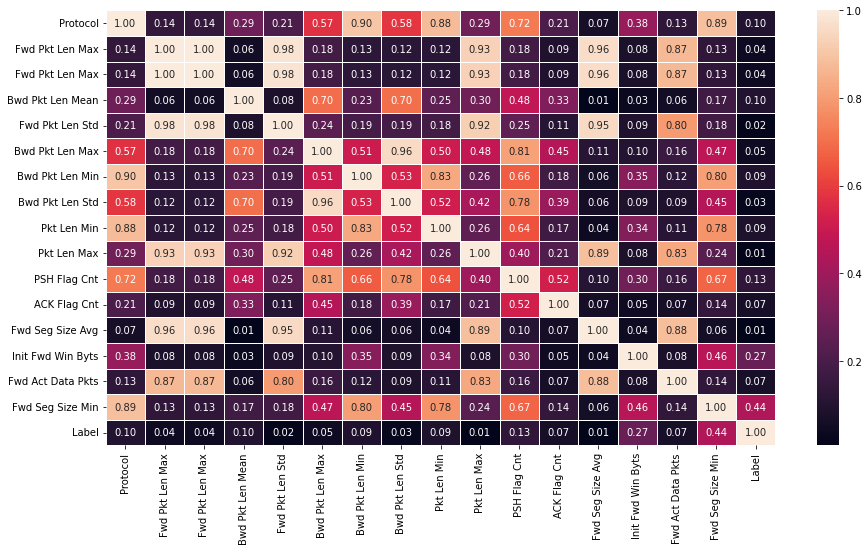

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(abs(toTrainModel.corr()), annot=True,
            linewidths=0.5, fmt='.2f', ax=ax)


Save label

In [132]:
toTrainModel = toTrainModel.replace(np.nan, 0)
toTrainModel = toTrainModel.replace(np.inf, 0)

allDatasetToTest = allDatasetToTest.replace(np.nan, 0)
allDatasetToTest = allDatasetToTest.replace(np.inf, 0)


In [133]:
labels = toTrainModel['Label']
toTrainModel = toTrainModel.drop(['Label'], axis=1)


In [134]:
labelsToTest = allDatasetToTest['Label']
allDatasetToTest = allDatasetToTest.drop(['Label'], axis=1)


In [ ]:
# toTrainModel = toTrainModel.drop(['Fwd Seg Size Min'], axis=1)


In [135]:
print('Is any Nan:', np.any(np.isnan(toTrainModel)))
print('Is all finite:', np.all(np.isfinite(toTrainModel)))


Is any Nan: False
Is all finite: True


In [136]:
from sklearn.preprocessing import StandardScaler


def scale(dataToTransform, columntoTransform):

    ss_dict = {col: StandardScaler() for col in columntoTransform}

    for colKey in columntoTransform:
        dataToTransform[colKey] = ss_dict[colKey].fit_transform(
            np.array(dataToTransform[colKey]).reshape(-1, 1))

    return dataToTransform


Scale numeric values

In [137]:
numericColumntoTransform = toTrainModel.keys()
toTrainModel = scale(toTrainModel, numericColumntoTransform)


ValueError: Length of values (12414) does not match length of index (6207)

In [ ]:
numericColumntoTransform = allDatasetToTest.keys()
allDatasetToTest = scale(allDatasetToTest, numericColumntoTransform)


#### After preprocess

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    toTrainModel, labels, test_size=0.33, random_state=32)


In [139]:
X_trainTest, X_testTest, y_trainTest, y_testTest = train_test_split(
    allDatasetToTest, labelsToTest, test_size=0.33, random_state=32)


In [140]:
isRFC = True
isMLPC = False
isSequential = False


In [141]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense


def model():
    if isRFC:
        model = RandomForestClassifier(
            n_estimators=100, max_depth=5, min_samples_leaf=4)
    elif isMLPC:
        model = MLPClassifier(random_state=32)
    else:
        model = Sequential([
            Dense(256, activation='softplus', kernel_initializer='glorot_uniform',
                  input_dim=X_train.shape[1]),
            Dense(128, activation='softplus',
                  kernel_initializer='glorot_uniform'),
            Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam')

    return model


In [142]:
model = model()


In [143]:
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=4)

In [144]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def confMatrix(yTrain, xTrainPreds, yTest, xTestPreds):
    # Your code here
    cmTrain = confusion_matrix(yTrain, xTrainPreds)
    X_train_disp = ConfusionMatrixDisplay(confusion_matrix=cmTrain)

    cmTest = confusion_matrix(yTest, xTestPreds)
    X_test_disp = ConfusionMatrixDisplay(confusion_matrix=cmTest)
    # End

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

    X_train_disp.plot(ax=ax[0])
    ax[0].set_title("Train")

    X_test_disp.plot(ax=ax[1])
    ax[1].set_title("Test")
    plt.show()


In [145]:
from sklearn.metrics import roc_auc_score, accuracy_score

X_train_preds = model.predict(X_train)
X_test_preds = model.predict(X_test)

if isSequential:
    print('Train auc:', roc_auc_score(y_train, X_train_preds))
    print('Test auc:', roc_auc_score(y_test, X_test_preds))
else:
    print('Train accuracy: ', accuracy_score(y_train, X_train_preds))
    print('Test accuracy: ', accuracy_score(y_test, X_test_preds))


Train accuracy:  0.9997594997594997
Test accuracy:  0.9990239141044412


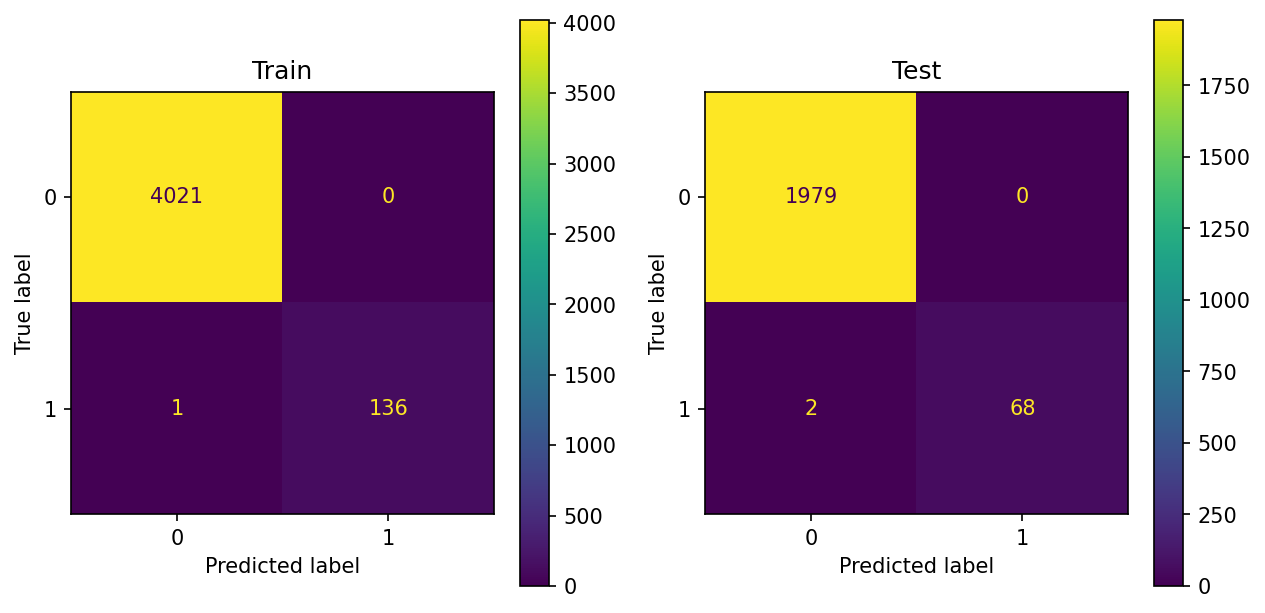

In [146]:
confMatrix(y_train, X_train_preds, y_test, X_test_preds)


In [147]:
X_trainTest_preds = model.predict(X_trainTest)
X_testTest_preds = model.predict(X_testTest)

if isSequential:
    print('Train auc:', roc_auc_score(y_trainTest, X_trainTest_preds))
    print('Test auc:', roc_auc_score(y_testTest, X_testTest_preds))
else:
    print('Train accuracy: ', accuracy_score(y_trainTest, X_trainTest_preds))
    print('Test accuracy: ', accuracy_score(y_testTest, X_testTest_preds))

Train accuracy:  0.7260189738735597
Test accuracy:  0.7264774730514695


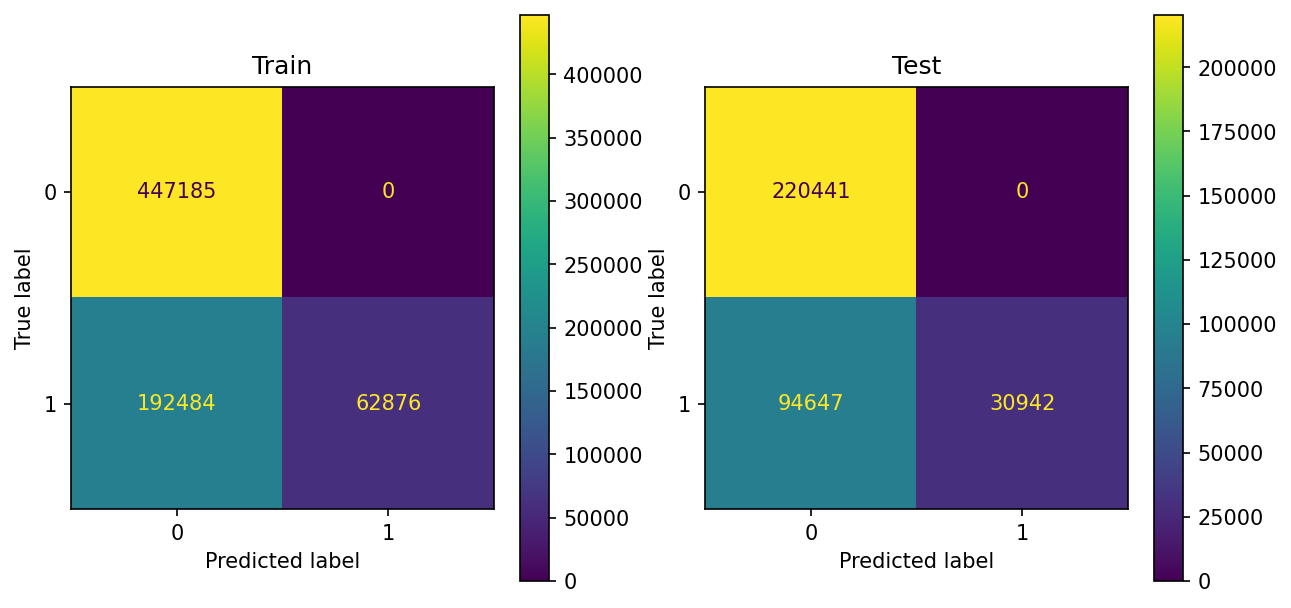

In [148]:
confMatrix(y_trainTest, X_trainTest_preds, y_testTest, X_testTest_preds)


In [149]:
# toTrainModel.to_csv('test.csv', index=False)
# print("Ready")
